AGN selections

In [3]:
import pandas as pd
import numpy as np
# import itertools as it

import pickle as pcl

from scipy.spatial.distance import cdist
from scipy.stats import binned_statistic

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [4]:
from palettable.tableau import GreenOrange_12

cmap = GreenOrange_12.hex_colors

In [5]:
import hightolowz

In [6]:
redshifts = ['2p07','3p10','3p95','5p03','5p92','6p97']
zees = [2.07,3.10,3.95,5.03,5.92,6.97]

In [5]:
selection = 'mstar'

gals = [None] * len(redshifts)

for i, redshift in enumerate(redshifts):

    gals[i] = pd.read_csv('data/r200/henriques2015a_z%s_%s_r200.csv' % (redshift, selection), skiprows=114, skipfooter=1, engine='python')

    gals[i] = pd.concat([gals[i], pd.read_csv('data/r200/dgal_%s_%s_r5_gals.csv' % (selection, redshift))], axis=1)
    gals[i] = pd.concat([gals[i], pd.read_csv('data/r200/dgal_%s_%s_r7.5_gals.csv' % (selection, redshift))], axis=1)
    gals[i] = pd.concat([gals[i], pd.read_csv('data/r200/dgal_%s_%s_r12.5_gals.csv' % (selection, redshift))], axis=1)
    gals[i] = pd.concat([gals[i], pd.read_csv('data/r200/dgal_%s_%s_r20_gals.csv' % (selection, redshift))], axis=1)

IOError: File data/r200/dgal_mstar_2p07_r5_gals.csv does not exist

In [ ]:
i = 0

epsilon = 0.1
c = 2.97e8 # m s^-1
Mdot = gals[i]['zn_quasarAccretionRate'] * 1.989e30 / (365.25*24*60*60)

Lbol = epsilon * Mdot * c**2  # J s^-1
Lbol *= 1e7  # erg s^-1

quasar_mask = Lbol > 1e44

In [ ]:
np.sum(Lbol > 1e44)

In [ ]:
epsilon = 0.1
c = 2.97 * 10**8 # m s^-1

fig = plt.figure(figsize=(11,10))

gs1 = gridspec.GridSpec(32, 16)

gs1.update(bottom = 0.57, top = 1, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs1[0:26,0:8])
ax2 = fig.add_subplot(gs1[0:26,8:16])

ax5 = fig.add_subplot(gs1[26:32,0:8])
ax6 = fig.add_subplot(gs1[26:32,8:16])


gs2 = gridspec.GridSpec(32, 16)

gs2.update(top=0.49, bottom=0.05, hspace=0, wspace=0)

ax3 = fig.add_subplot(gs2[0:26,0:8])
ax4 = fig.add_subplot(gs2[0:26,8:16])

ax7 = fig.add_subplot(gs2[26:32,0:8])
ax8 = fig.add_subplot(gs2[26:32,8:16])

ax9 = fig.add_subplot(gs2[14:23,12:16])

Bhatta =[[] for i in range(len(redshifts))]

## Subplots
BinLimits = [np.linspace(-1, 4.2, 27), np.linspace(-1, 8, 31), np.linspace(-1, 17, 37), np.linspace(-2, 60, 32)]
Bins = [np.linspace(-0.9, 4.1, 26), np.linspace(-0.85, 7.85, 30), np.linspace(-0.75, 16.75, 36), np.linspace(-1, 59, 31)]


for i, redshift in enumerate(redshifts[:5]):
    
    Mdot = gals[i]['zn_quasarAccretionRate'] * 1.989 * 10**30 / (365.25*24*60*60)

    Lbol = epsilon * Mdot * c**2  # J s^-1
    Lbol /= 1e-7  # erg s^-1
    
    quasar_mask = Lbol > 1e44

    mask = ~np.isnan(np.log10(gals[i]['z0_central_mcrit200'] * 1e10))
    
    for axt, axb, R, binLimits, bins in zip([ax1,ax2,ax3,ax4], [ax5,ax6,ax7,ax8], 
                                            ['20','12.5','7.5','5'], BinLimits, Bins):
        
        # Subplot
        phiB, mass = np.histogram(gals[i][quasar_mask & (gals[i]['z0_central_mcrit200'] < 1e4)]['delta_gal_%s'%R],
                                     bins=binLimits, normed=True)
        
        
        phiA, mass = np.histogram(gals[i][quasar_mask & (gals[i]['z0_central_mcrit200'] >= 1e4)]['delta_gal_%s'%R],
                                 bins=binLimits, normed=True)
        
        DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        Bhatta[i].append(DB)
        
        axb.set_xlim(binLimits[0], binLimits[-1])
        axt.set_xlim(binLimits[0], binLimits[-1])

        # Main Plot
        median = binned_statistic(gals[i][quasar_mask]['delta_gal_%s'%R][mask], 
                          np.log10(gals[i][quasar_mask]['z0_central_mcrit200'] * 1e10)[mask],
                          bins=binLimits, statistic='median')[0]

        count = binned_statistic(gals[i][quasar_mask]['delta_gal_%s'%R][mask], 
                                  np.log10(gals[i][quasar_mask]['z0_central_mcrit200'] * 1e10)[mask],
                                  bins=binLimits, statistic='count')[0]

        std = binned_statistic(gals[i][quasar_mask]['delta_gal_%s'%R][mask], 
                                 np.log10(gals[i][quasar_mask]['z0_central_mcrit200'] * 1e10)[mask],
                                 bins=binLimits, statistic='std')[0]

        cmask = (count > 20)
        
        axt.fill_between(bins[cmask], median[cmask]+std[cmask], median[cmask]-std[cmask], 
                         alpha=0.1, linewidth=0, color=cmap[i*2])
        
        axt.plot(bins[cmask], median[cmask], color=cmap[i*2], label='$z = %s$'%redshift)
        
        axt.scatter(gals[i][quasar_mask & (gals[i]['delta_gal_%s'%R] > max(bins[cmask]))]['delta_gal_%s'%R],
            np.log10(gals[i][quasar_mask & (gals[i]['delta_gal_%s'%R] > max(bins[cmask]))]['z0_central_mcrit200'] * 1e10),
            marker='.', s=8, c=cmap[i], lw=0, label=None)

        axt.plot(bins[cmask], median[cmask], color=cmap[i*2], linestyle='dotted')

        axt.hlines(14, -10, 60, linestyle='--', color='grey')
        
        axt.set_xticklabels([])

        axb.step(bins, phiA, color=cmap[i*2], alpha=1)# + i*0.1)
        axb.step(bins, phiB, color=cmap[i*2], linestyle='dotted', alpha=1)# + i*0.1)

        phi, mass = np.histogram(gals[i]['delta_gal_%s'%R], bins=binLimits, normed=True)

        if(i==0):
            axt.text(0.05, 0.9, '$R = %s \, \mathrm{Mpc / h}$'%R, transform=axt.transAxes, size=12)
            


for i,z in enumerate(redshifts):
    ax9.plot([20,12.5,7.5,5], Bhatta[i], color=cmap[i*2])
    
ax9.set_xlabel('$R$')
ax9.set_ylabel('$D_{B}$')

ax9.set_xticklabels([4,6,8,10,12,14,16,18,''])
ax9.set_yticklabels(['',0.2,0.3,0.4,0.5,0.6,0.7,''])

ax9.vlines(7.5, 0, 0.7, colors='grey', linestyles='dotted')

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(12.5,15.5)

## Legend
line1 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax5.legend(handles=[line1, line2], 
           labels=['$M_{200} / M_{\odot} \; \geqslant \; 10^{14}$',
                   '$M_{200} / M_{\odot} \; < \; 10^{14}$'], 
           loc=1, prop={'size':10}, frameon=False)

ax1.legend(loc=4, frameon=False)

ax2.set_yticklabels([])
ax4.set_yticklabels([])

ax6.yaxis.tick_right()
ax8.yaxis.tick_right()

fig.text(0.5, 0.53, '$\delta_{g}\,(z_{n})$', size=15, ha='center')  # common X 1
fig.text(0.5, 0.01, '$\delta_{g}\,(z_{n})$', size=15, ha='center')  # common X 2
fig.text(0.05, 0.82, '$\mathrm{log_{10}}(M_{200} / M_{\odot})$', va='center', size = 15, rotation='vertical')  # common Y 1
fig.text(0.05, 0.32, '$\mathrm{log_{10}}(M_{200} / M_{\odot})$', va='center', size = 15, rotation='vertical')  # common Y 2

# plt.savefig('../papers/hightolowz/images/quasar_select.png', bbox_inches='tight', dpi=300)

In [11]:
from periodic_kdtree import PeriodicCKDTree

def calc_agn_frac(gals, L):

    cluster_ids = pd.unique(gals[gals['z0_central_mcrit200'] > 1e4]['z0_centralId'])
    
    N_agn = [None] * len(cluster_ids)

    dimensions = np.array([L, L, L])

    print "Building periodic KDtree..."
    T = PeriodicCKDTree(dimensions, gals[['zn_x','zn_y','zn_z']])
    
    print "Looping through clusters..."    
    for i, cluster in enumerate(cluster_ids):
        
        Mdot = gals[gals['z0_centralId']==cluster]['zn_quasarAccretionRate'] * 1.989 * 10**30 / (365.25*24*60*60)
        Lbol = epsilon * Mdot * c**2 / 1e-7  # erg s^-1
        N_agn[i] = np.sum(Lbol > 1e44)

        
    return N_agn, len(cluster_ids)

In [12]:
nagn = [None] * len(redshifts)
n_clust = [None] * len(redshifts)

for i,z in enumerate(redshifts):
    nagn[i], n_clust[i] = calc_agn_frac(gals[i], 480.279)

Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...


In [13]:
agn_in_pcs = [None] * len(gals)
all_agn = [None] * len(gals)

for i in range(len(gals)):
    clust = gals[i]['z0_central_mcrit200'] > 1e4
    
    Mdot = gals[i]['zn_quasarAccretionRate'] * 1.989 * 10**30 / (365.25*24*60*60)
    Lbol = epsilon * Mdot * c**2 / 1e-7  # erg s^-1
    agn_in_pcs[i] = float(np.sum((Lbol > 1e44) & clust))
    all_agn[i] = np.sum(Lbol > 1e44)

(2, 50000.0)

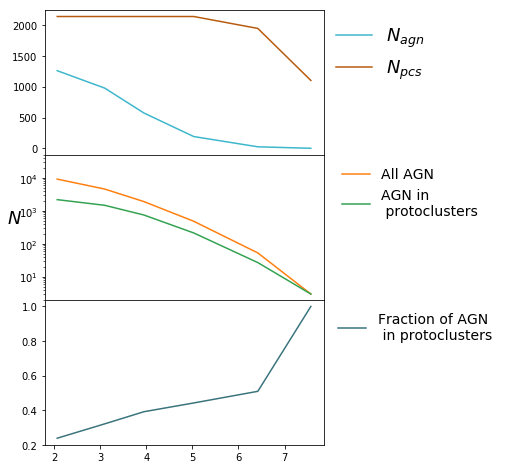

In [14]:
fig = plt.figure(figsize=(5,8))

gs = gridspec.GridSpec(3, 1)

gs.update(hspace=0, wspace=0) # bottom = 0.57, top = 1, 

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

ax1.plot(zees, [np.sum([x > 0 for x in y]) for y in nagn], label='$N_{agn}$', c=cmap[4])
ax1.plot(zees, n_clust, label='$N_{pcs}$', c=cmap[6])

ax2.set_ylabel('$N$', size=18, rotation=0)
ax1.set_xlabel('$z$', size=20)

ax1.legend(frameon=False, prop={'size':18}, bbox_to_anchor=(1.42, 1))

ax2.semilogy(zees, all_agn, c=cmap[2], label='All AGN')
ax2.semilogy(zees, agn_in_pcs, c=cmap[0], label='AGN in \n protoclusters')

ax2.legend(frameon=False, prop={'size':14}, bbox_to_anchor=(1.6, 1))

ax3.plot(zees, np.array(agn_in_pcs)/np.array(all_agn),c=cmap[8], label='Fraction of AGN \n in protoclusters')

ax3.legend(frameon=False, prop={'size':14}, bbox_to_anchor=(1.65, 1))

ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax2.set_ylim(2,5e4)

# plt.savefig('../papers/hightolowz/images/agn_stats.png', bbox_inches='tight', dpi=300)

In [84]:
i = 0

Mdot = gals[i]['zn_quasarAccretionRate'] * 1.989 * 10**30 / (365.25*24*60*60)
Lbol = epsilon * Mdot * c**2 / 1e-7  # erg s^-1

lim = 1e44
qmask = Lbol > lim

print np.sum(qmask), np.sum(~qmask)

9193 1733854


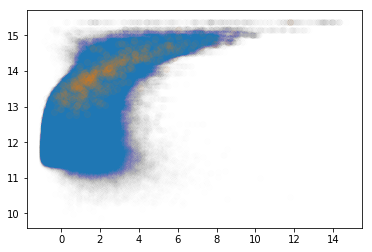

In [63]:
plt.scatter(gals[i]['delta_gal_7.5'][~qmask], 
            np.log10(gals[i]['z0_central_mcrit200'][~qmask] * 1e10), alpha=0.005)

plt.scatter(gals[i]['delta_gal_7.5'][qmask], 
            np.log10(gals[i]['z0_central_mcrit200'][qmask] * 1e10), alpha=0.05)


In [83]:
i = 0
rmask = gals[i]['zn_radioAccretionRate'] > 0.001
print np.sum(rmask), np.sum(~rmask)

36143 1706904


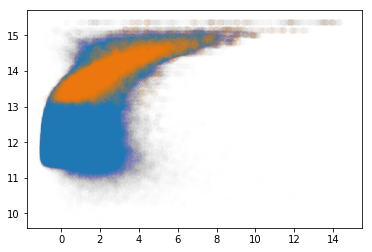

In [65]:
plt.scatter(gals[i]['delta_gal_7.5'][~rmask], 
            np.log10(gals[i]['z0_central_mcrit200'][~rmask] * 1e10), alpha=0.005)

plt.scatter(gals[i]['delta_gal_7.5'][rmask], 
            np.log10(gals[i]['z0_central_mcrit200'][rmask] * 1e10), alpha=0.05)


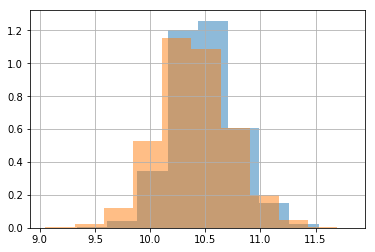

In [85]:
np.log10(gals[i]['zn_stellarMass'][rmask] * 1e10).hist(normed=1, alpha=0.5)
np.log10(gals[i]['zn_stellarMass'][qmask] * 1e10).hist(normed=1, alpha=0.5)

In [78]:
i = 3

# Radio Power
mdot = gals[i]['zn_radioAccretionRate'] * 1.989e30 / (365.25 * 24 * 60 * 60)
Pjet = mdot * c**2 * 1e7    # erg s^-1

radio_mask = Pjet > 1e42

print np.sum(radio_mask), np.sum(~radio_mask)

# Quasar Luminosity
epsilon = 0.1
c = 2.97e8 # m s^-1
Mdot = gals[i]['zn_quasarAccretionRate'] * 1.989e30 / (365.25*24*60*60)

Lbol = epsilon * Mdot * c**2 * 1e7  # erg s^-1

quasar_mask = Lbol > 1e43

print np.sum(quasar_mask), np.sum(~quasar_mask) 

3045 150863
3640 150268


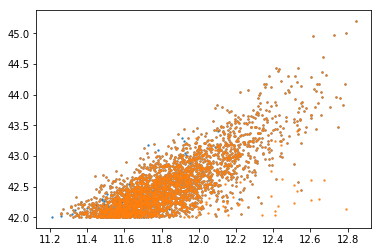

In [85]:
plt.scatter(np.log10(gals[i]['zn_mvir'][radio_mask] * 1e10), 
            np.log10(Pjet[radio_mask]), s=2, alpha=0.8)

plt.scatter(np.log10(gals[i]['zn_centralMvir'][radio_mask] * 1e10), 
            np.log10(Pjet[radio_mask]), s=2, alpha=0.8)

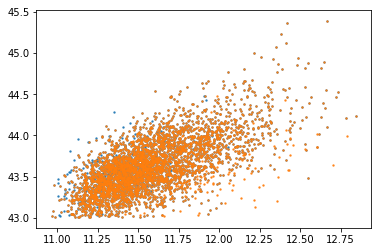

In [90]:
plt.scatter(np.log10(gals[i]['zn_mvir'][quasar_mask] * 1e10), 
            np.log10(Lbol[quasar_mask]), s=2, alpha=0.8)

plt.scatter(np.log10(gals[i]['zn_centralMvir'][quasar_mask] * 1e10), 
            np.log10(Lbol[quasar_mask]), s=2, alpha=0.8)

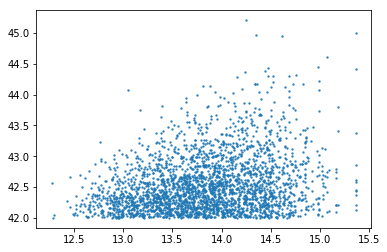

In [88]:
plt.scatter(np.log10(gals[i]['z0_central_mcrit200'][radio_mask] * 1e10), 
            np.log10(Pjet[radio_mask]), s=2, alpha=0.8)

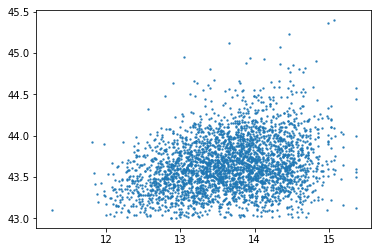

In [89]:
plt.scatter(np.log10(gals[i]['z0_central_mcrit200'][quasar_mask] * 1e10), 
            np.log10(Lbol[quasar_mask]), s=2, alpha=0.8)

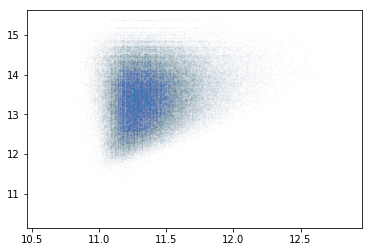

In [79]:
plt.scatter(np.log10(gals[i]['zn_mvir'] * 1e10), 
            np.log10(gals[i]['z0_central_mcrit200'] * 1e10), s=1, alpha=0.01)

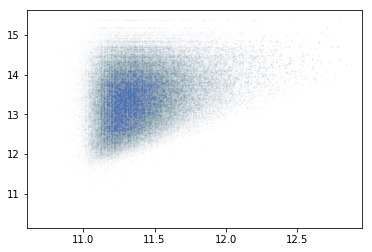

In [84]:
plt.scatter(np.log10(gals[i]['zn_centralMvir'] * 1e10), 
            np.log10(gals[i]['z0_central_mcrit200'] * 1e10), s=1, alpha=0.01)